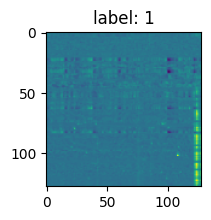

In [1]:
from radburst.utils.dataset import Dataset, MinMaxNormalize, Resize
import radburst.utils.preprocessing as prep
from torchvision import transforms
import matplotlib.pyplot as plt
from radburst.detection.ml.models.cnn import CNN
from radburst.detection.ml.predict import Predictor
import numpy as np
import torch


# Provide path to dataset and labels file
data_path = '/mnt/c/Users/camer/OneDrive/Documents/radburst/data/Fitfiles'
labels_path = '/mnt/c/Users/camer/OneDrive/Documents/radburst/data/labels/filtered-labels-20240309-20240701.csv'

# Collect functions to preprocess data samples
preprocess_steps = transforms.Compose([
    prep.stan_rows_remove_verts,
    Resize((128,128)),
    MinMaxNormalize()
])

# Create dataset using above settings
dataset = Dataset(
    data_dir= data_path,
    labels= labels_path,
    preprocess= preprocess_steps
)

# Plot a sample
plt.figure(figsize=(2, 2))
spect, label = dataset[1000]
plt.imshow(torch.squeeze(spect), aspect='auto')
plt.title(f'label: {int(label.item())}')
plt.show()

In [2]:
# Create model instance
model = CNN()
path_saved_model = "/mnt/c/Users/camer/OneDrive/Documents/radburst/radburst/detection/ml/trained_models//cnn-03-13-2024.pth"

# Load trained state
state_dict = torch.load(path_saved_model, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [3]:
# Create dataloader for predictions on full dataset

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=False
)

predictor = Predictor(model)

# Make predictions 
# (uncomment next line and run with different settings or load existing predictions in next cell)
#predictions, true_labels = predictor.predict(data_loader)

# Save predictions
#np.savez('cnn_pred_and_labels.npz', preds=predictions, labels=true_labels)

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [08:29<00:00,  3.75s/it]


In [16]:
# Load predictions
data = np.load('cnn_pred_and_labels.npz')
preds, labs = data['preds'], data['labels']

# Current predictions are probabilities [0,1], need to convert to discrete 0 or 1 using a threshold
threshold = .5
rounded_preds = np.where(preds >= threshold, 1, 0)

Precision: 0.30
Recall: 0.24
F1 Score: 0.27


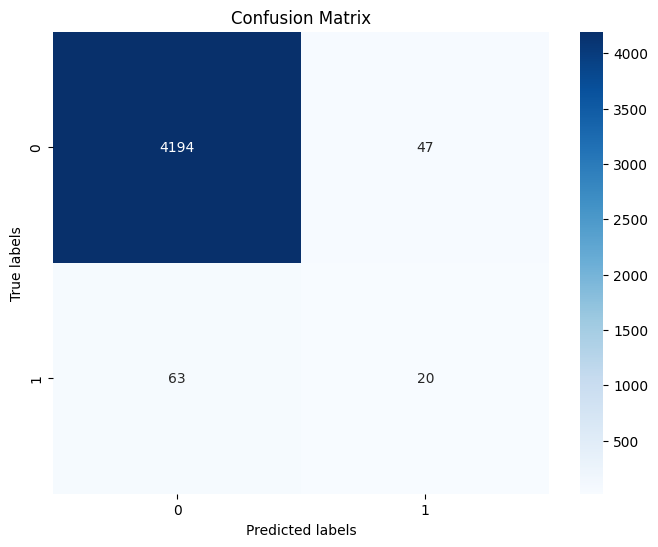

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
conf_matrix = confusion_matrix(labs, rounded_preds)

# Calculate precision, recall, and F1 score
precision = precision_score(labs, rounded_preds, average='binary')
recall = recall_score(labs, rounded_preds, average='binary')
f1 = f1_score(labs, rounded_preds, average='binary')

# Print the scores
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Add axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


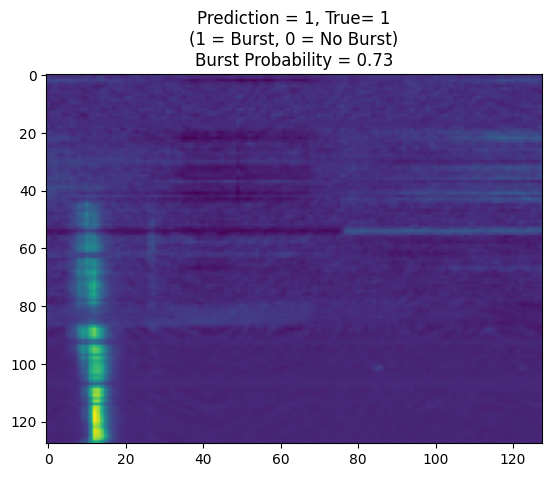

In [45]:
# Get indices to visualize correct predictions and mistakes
true_positives = np.where((labs == 1) & (rounded_preds == 1))[0]    # pred: burst      actual: burst
false_positives = np.where((labs == 0) & (rounded_preds == 1))[0]   # pred: burst      actual: no burst
false_negatives = np.where((labs == 1) & (rounded_preds == 0))[0]   # pred: no burst   actual: burst

for i in true_positives:
    spect, label = dataset[i]
    burst_prob = preds[i]
    pred_label = rounded_preds[i]
    
    plt.imshow(torch.squeeze(spect), aspect='auto')
    plt.title(f'Prediction = {pred_label.item()}, True= {int(label.item())}\n(1 = Burst, 0 = No Burst)\nBurst Probability = {burst_prob[0]:.2f}')
    plt.show()
    break